# Exploratory Data Analysis

In [127]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data0910 = pd.read_excel("online_retail_II.xlsx", sheet_name=0)
data1011 = pd.read_excel("online_retail_II.xlsx", sheet_name=1)

In [170]:
data = data0910.append(pd.DataFrame(data = data1011), ignore_index=True)

In [8]:
print('DataFrame dimensions:', data.shape)

Dataframe dimensions: (824364, 8)


In [7]:
data.columns.values

array(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'], dtype=object)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 9 columns):
Invoice        824364 non-null object
StockCode      824364 non-null object
Description    824364 non-null object
Quantity       824364 non-null int64
InvoiceDate    824364 non-null datetime64[ns]
Price          824364 non-null float64
Customer ID    824364 non-null float64
Country        824364 non-null object
Cancelled      824364 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 97.4+ MB


## Attribute Information:

**Invoice**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

**StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

**Description**: Product (item) name. Nominal.

**Quantity**: The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.

**UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).

**Customer ID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

**Country**: Country name. Nominal. The name of the country where a customer resides.

## Preprocessing

In this section I do the following:
- Prepare InvoiceDate and Invoice by converting them
- Create a new feature for order revenue
- Drop cancelled orders
- Remove observation with out-of-place Descriptions, Customer IDs, and StockCodes
- Removed Outliers

In [171]:
# Create new feature for order revenue
data['Revenue'] = data['Quantity'] * data['Price']

# Convert date to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create new dummy variable for cancelled orders
data['Cancelled'] = data['Invoice'].str.startswith("C")
data['Cancelled'] = data['Cancelled'].fillna(False)
data = data[data['Cancelled'] == False]
data.drop('Cancelled', axis = 1, inplace = True)

# Convert invoice number to integer
data['Invoice'].replace("\D+", r'', regex=True, inplace=True)
data['Invoice'].astype('int', inplace = True)

# Remove shipping invoices
data = data[(data['StockCode'] != 'POST') & (data['StockCode'] != 'DOT')]

# Remove those with odd descriptions
data = data[data['Description'].str.startswith('?') == False]
data = data[data['Description'].str.isupper() == True]
data = data[data['Description'].str.contains("LOST") == False]

# Retain values with Customer ID's
data.dropna(axis = 0, subset = ['Customer ID'], inplace = True)
data['Customer ID'] = data['Customer ID'].astype(int)

# Lazy remove outliers
data = data[( data['Quantity'] > 0) & (data['Quantity'] < data['Quantity'].quantile(.98))]

In [172]:
data['Quantity'].describe()

count    783853.000000
mean          8.682661
std          10.820130
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max          95.000000
Name: Quantity, dtype: float64

In [173]:
print('DataFrame dimensions:', data.shape)

DataFrame dimensions: (783853, 9)


In [174]:
data.columns.values

array(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Revenue'], dtype=object)

### Countries

In [144]:
print('Number of Unique Countries:', data['Country'].nunique())

Number of Unique Countries: 41


#### Invoices by Country

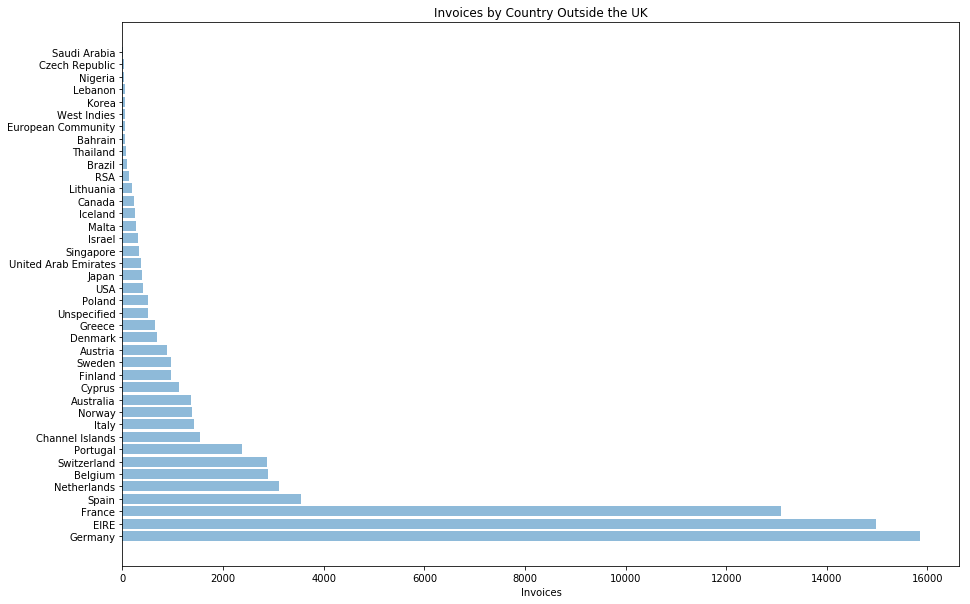

In [155]:
fig, ax = plt.subplots(1, figsize=(15, 10))

country_counts = data[['Country','Customer ID']].groupby('Country').count()
country_counts.columns = ['Count']
country_counts = country_counts.sort_values(by ='Count', ascending = False)

temp = country_counts.drop('United Kingdom')

plt.barh(temp.index, temp['Count'], align='center', alpha=0.5)
plt.xlabel('Invoices')
plt.title('Invoices by Country Outside the UK')

plt.show()

In [152]:
print("Number of Invoices in the UK:", country_counts.loc['United Kingdom'][0])

Number of Invoices in the UK: 709784


#### Average Invoice Revenue by Country

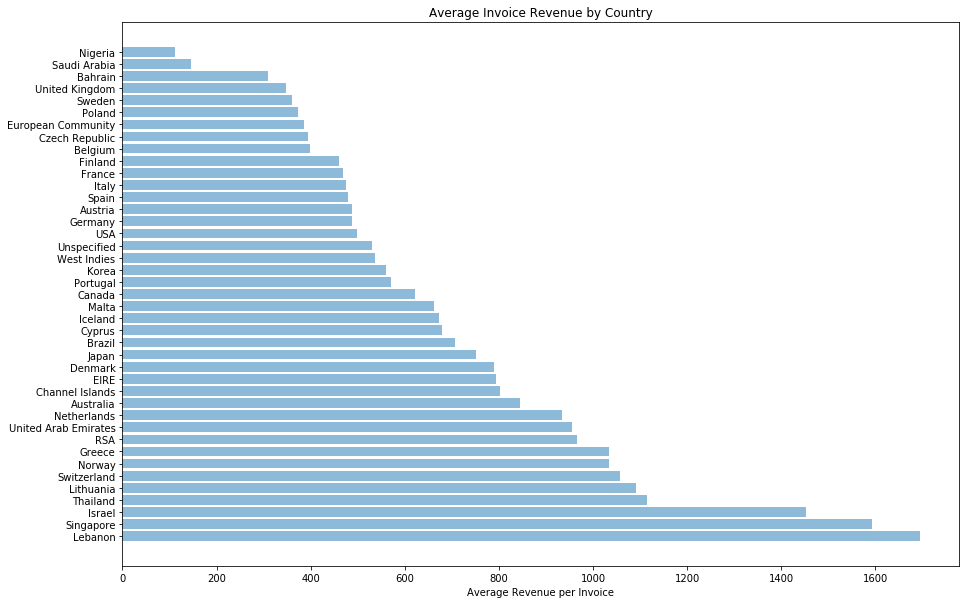

In [167]:
fig, ax = plt.subplots(1, figsize=(15, 10))

rev_country = data.groupby(['Country', 'Invoice'])['Revenue'].sum().reset_index()
rev_country = rev_country.groupby(['Country'])['Revenue'].mean().sort_values(ascending = False)

plt.barh(rev_country.index.values, rev_country, align='center', alpha=0.5)
plt.xlabel('Average Revenue per Invoice')
plt.title('Average Invoice Revenue by Country')
plt.show()

### Customers

In [49]:
print('Number of Unique Costumers:', data['Customer ID'].nunique())

Number of Unique Costumers: 5942


# Write out data

In [176]:
data.to_csv("clean_customer_retail.csv")